# Adaptive distances ABC-SMC 
Set up requrirements and experimental data

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Jun 22 18:22:52 2020

@author: marcofking
"""
import pyabc as pyabc
from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition)
from pyabc.visualization import plot_kde_2d, plot_data_callback
import matplotlib.pyplot as plt
import os
import tempfile
import numpy as np
#import scipy as sp
from scipy.integrate import odeint
import math
import seaborn as sns
import pandas as pd
#pyabc.settings.set_figure_params('pyabc')  # for beautified plots
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test5.db"))



# Plot the data

An experiment was carried out in a biological research facilitiy whre one hand from 10 people (left or right) was cleaned with a sanitiser. Their other hand was sampled as a control. Over the next 6 hours 5 participants hands' were sampled every hour for microorganisms, after which these 5 left. The other 5 participants (who had not been previously sampled but had been treated) were then sampled from hours 16 to 24 after sanitiser application.

The following plot shows the mean and standard deviation plotted at each time-point.

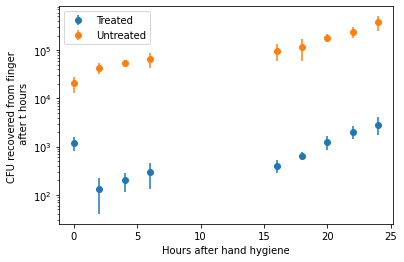

In [7]:
#read gerba_data_summary.csv from Data
gerba_data_summary = pd.read_csv("../Data/gerba_data_summary.csv")


#Create a vector of values 0,2,4,6,16,18,20,22,24
x = np.array([0,2,4,6,16,18,20,22,24])

#Plot the time vs mean from gerba_data_mean for treatment type 1
plt.errorbar(x,gerba_data_summary[gerba_data_summary['treatment']=='Treated']['mean'],yerr=gerba_data_summary[gerba_data_summary['treatment']=='Treated']['sd'],fmt='o',label='Treated')
plt.errorbar(x,gerba_data_summary[gerba_data_summary['treatment']=='Untreated']['mean'],yerr=gerba_data_summary[gerba_data_summary['treatment']=='Untreated']['sd'],fmt='o',label='Untreated')
plt.yscale("log")
plt.xlabel("Hours after hand hygiene")
plt.ylabel("CFU recovered from finger \n after t hours")
plt.legend(loc="upper left")

# Define the ODE to solve  - We use ODE 1.

1) We consider only recontamination from surface contacts, not from additional proliferation of the bacterias on the hands.
$$ y'=(1-\dfrac{y}{C})r-d\exp(-g t)y$$

$C$ is carrying capacity. $d$ is maximum effecicacy. $g$ is decay from the disinfectant.

2) If we wanted to consider proliferation on hands as well as from surface contacts then we could use:
$$ y'=y(1-\dfrac{y}{C})l-d\exp(-g t)y$$

where $l$ is the rate at which microorganisms proliferate on hands. E.g. reproduction.

3) Proliferation and increase from contacts can be combined:
$$ y'=(yl+r)(1-\dfrac{y}{C})-d\exp(-g t)y$$

However with the data we have it is unlikely that we can learn about y and r together.

Currently we only consider the first 4 experimental datapoints as there is a gap which is hard to explain using this model-

Notes: 12th April
- We can first try to fit the model to the data from group 2's washed hand to learn only about $C$ and $r$.
- Then with those learned $C$ and $r$ we can fit the model to the data from group 1's washed hand to learn only about $d$ and $g$. 
- But we never reach a saturation so maybe we shouldn't consider $C$ at all.

In [8]:
#Here we defien the ODE model
def ode_model(contamination,t,r,C,d,g):
    Contamination = contamination;
    return(r*(1-Contamination/C)-d*math.exp(-g*t)*Contamination)

#Here we create the input parameters and extract only specific time-points
def deterministic_run(parameters):#precision,initial_contamination,r,C,d,g):
    precision=5000
    tmax = 6
    time_space = np.linspace(0,tmax,precision+1)#precision+1?
    sim=odeint(ode_model,initial_contamination,time_space,args=(parameters["r"],parameters["C"],parameters["d"],parameters["g"]))
    #num_at_0=sim[int(precision*0.1/50.0)]
    #num_at_1=sim[int(precision*1/tmax)]
    num_at_2=sim[int(precision*2/tmax)]
    num_at_4=sim[int(precision*4/tmax)]
    num_at_6=sim[int(precision*6/tmax)]
   # num_at_16=sim[int(precision*16/tmax)]
   # num_at_18=sim[int(precision*18/tmax)]
   # num_at_20=sim[int(precision*20/tmax)]
   # num_at_22=sim[int(precision*22/tmax)]
   # num_at_24=sim[int(precision*24/tmax)]
    #return{"Contamination":[num_at_2,num_at_4,num_at_6,num_at_16,num_at_18,num_at_20,num_at_22,num_at_24]+ sigma*np.random.randn(8)}
    return{"Contamination":[num_at_2,num_at_4,num_at_6]}

# Define the parameter priors

We choose some examples to see how well it works.

In [9]:
parameter_prior = Distribution(r=RV("uniform", 0.0, 200.0),
                               C=RV("uniform", 1000.0, 6000.0),
                               d=RV("uniform", 10.0, 1000.0),
                               g=RV("uniform", 2.0, 200.0))

#parameter_prior.get_parameter_names()

# Define the distance fuction
We propose to use the PCMAD (Perhaps-Combined MAD), which either uses MAD, or, if the fraction of severe outliers detected is not too high (precisely not more than 1/3, see the publication and the API for details), uses MAD + MADO, where MADO is the median absolute deviation to the observed value.

see https://pyabc.readthedocs.io/en/latest/examples/adaptive_distances.html

In [10]:
#Original Euclidean distance weighted by sd at each time-point
# # def distance(simulation, data):
#     return np.absolute((data["Contamination"] - simulation["Contamination"])/data["sd"]).sum()


# Set up the ABC SMC 


In [11]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(models=deterministic_run,parameter_priors=parameter_prior, distance_function=distance)


ABC.Sampler INFO: Parallelize sampling on 8 processes.


# Setting the observed data

In [12]:
# y_observed is the important piece here: our actual observation.
initial_contamination=1200.0
measurement_data = np.array([134.0,202.0,294.0]) #,400,644,1232,2044,2868
s=np.array([93.70165,86.13942,162.11107])#,116.61904,123.61230,396.88789,628.87201,1147.13556])
precision=5000
measurement_times = np.array([2,4,6])#np.arange(len(measurement_data))  
# and we define where to store the results

history = abc.new(db_path, {"Contamination": measurement_data,"sd": s})

ABC.History INFO: Start <ABCSMC id=1, start_time=2022-04-21 20:22:31>


# Running the ABC

In [14]:
# We run the ABC until either criterion is met
history = abc.run(max_nr_populations=7)

ABC.History INFO: Done <ABCSMC id=1, duration=0:00:31.997366, end_time=2022-04-21 20:23:03>


TypeError: Cannot parse variable Contamination=[array([349.46401948]), array([679.40785313]), array([982.16835141])] of type <class 'list'> to numeric.

# Visualisations of Variables
Simulated trajectories plotted against observed experimental data

# Visualise the probability density functions


In [ ]:
from pyabc.visualization import plot_kde_matrix

df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w);

## Visualise how the parameters converge over populations

In [ ]:
fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df,
        w,
        xmin=0,
        xmax=40,
        x="r",
        xname=r"$r$",
        ax=ax,
        label=f"PDF t={t}",
    )
ax.axvline(20, color="k", linestyle="dashed")
ax.legend();

# Summary statistics

First some summary statistics and save to file

In [ ]:
df.to_csv("../Data/abc_results.csv", encoding='utf-8', index=False)
df.describe()

# Plot some trajectories


In [ ]:
import pandas as pd
import operator


#plot some curves from the ODE model
precision=5000
tmax = 6
time_space = np.linspace(0,tmax,precision+1)#precision+1?

P=odeint(ode_model,initial_contamination,time_space,args=(df["r"].mean(),df["C"].mean(),df["d"].mean(),df["g"].mean()))
Pmin=odeint(ode_model,initial_contamination,time_space,args=(df["r"].quantile(0.05),df["C"].quantile(0.05),df["d"].quantile(0.05),df["g"].quantile(0.05)))
Pmax=odeint(ode_model,initial_contamination,time_space,args=(df["r"].quantile(0.95),df["C"].quantile(0.95),df["d"].quantile(0.95),df["g"].quantile(0.95)))

#P=ode_model({"af":df["af"].mean(),"cs":df["cs"].mean(),"lam":df["lam"].mean()})
#Pmin=ode_model({"af":df["af"].quantile(0.05),"cs":df["cs"].quantile(0.05),"lam":df["lam"].quantile(0.05)})
#Pmax=ode_model({"af":df["af"].quantile(0.95),"cs":df["cs"].quantile(0.95),"lam":df["lam"].quantile(0.95)})

# create a vector of values between 0 and 6
x = np.array([0,2,4,6])

#Define new sd just for plotting to avoid SD value at 0
s=np.array([385,93.70165,86.13942,162.11107])
measurement_data = np.array([1200,134.0,202.0,294.0])

#Plot errobars of experimental data
x = np.array([0,2,4,6])
plt.errorbar(x,measurement_data,yerr=s,fmt='o', color='black',label='Experimental data')

#Plot the model prediction
plt.plot(time_space,P,label="Model prediction",color='blue')

#Plot confidence intervals around the model prediction
plt.fill_between(x,Pmin,Pmax,alpha=0.2,color='blue')



#plt.fill_between(x, np.array(map(operator.sub, P["Contamination"], Pmin["Contamination"])), np.array(map(operator.add, P["Contamination"], Pmax["Contamination"])), color='b', alpha=.1)
plt.xlim(-1,8)
plt.ylabel("CUF recovered from finger \n after t hours")
plt.xlabel("Number of contacts")
plt.legend(loc="upper left")


#save the plot
#plt.savefig("../Images/abc_prediction.png", dpi=600)

plt.show()

In [ ]:
#print the shape of time_space
print(odeint(ode_model,initial_contamination,time_space,args=(df["r"].mean(),df["C"].mean(),df["d"].mean(),df["g"].mean())))